In [1]:
ENV["GKS_ENCODING"] = "utf-8"
using NLsolve
using Plots
using SharedArrays

using Pkg
using HDF5
Pkg.activate("/home/julian/Hamburg/LadderDGA.jl")
using LadderDGA
using Logging

cfg_file2 = "/home/julian/Hamburg/lDGA_checks/spch_inf/config.toml";
cfg_file = "/home/julian/Hamburg/lDGA_shift_tests/data/20_20_s1_b12_u1.0/config_j_s.toml";

  Activating project at `~/Hamburg/LadderDGA.jl`
┌ Info: Precompiling LadderDGA [78e40beb-bf89-4c0e-9d2b-bee278912f2b]
└ @ Base loading.jl:1423


In [2]:
mP, sP, env, kGridsStr = readConfig(cfg_file)
impQ_sp, impQ_ch, GImp, kG_loc, kG, GLoc, GLoc_fft, Σ_loc, FUpDo  = setup_LDGA(kGridsStr[1], mP, sP, env);

[ Info: Reading Inputs...
[ Warning: Could not find E_kin_DMFT, E_pot_DMFT key in input
[ Warning: reading Hubbard Parameters from config. These should be supplied through the input jld2!
[ Info: Setting up calculation for kGrid 3Dsc-0.20412414523193150 of size 2
[ Warning: Improved sums usually require at least 30 positive fermionic frequencies
[ Info: setting usable ranges of sp and ch channel from 1:41 and 1:41 to the same range of 1:41
[ Warning: TODO: update local omega sum with correction
[ Warning: using unoptimized sum_freq
[ Warning: using unoptimized sum_freq
[ Warning: using unoptimized sum_freq
[ Warning: using unoptimized sum_freq
┌ Info: Inputs Read. Starting Computation.
│ Local susceptibilities with ranges are:
│ χLoc_sp(1:41) = 0.267, χLoc_ch(1:41) = 0.1771
└ sum χupup check (fit, tail sub, tail sub + fit, expected): 0.222029790804039 ?≈? 0.22202979080403903 ?=? 0.22202979080403903 ?≈? 0.25"


In [3]:
# "local" correction quantities
bubble_loc = calc_bubble(GImp, kG_loc, mP, sP);
locQ_sp = calc_χ_trilex(impQ_sp.Γ, bubble_loc, kG_loc, mP.U, mP, sP);
locQ_ch = calc_χ_trilex(impQ_ch.Γ, bubble_loc, kG_loc,-mP.U, mP, sP);
Σ_ladderLoc = calc_Σ(locQ_sp, locQ_ch, bubble_loc, GImp, FUpDo,
    kG_loc, mP, sP)[1,:] .+ mP.n * mP.U/2.0;
# ladder quantities
bubble = calc_bubble(GLoc_fft, kG, mP, sP);
nlQ_sp = calc_χ_trilex(impQ_sp.Γ, bubble, kG, mP.U, mP, sP);
nlQ_ch = calc_χ_trilex(impQ_ch.Γ, bubble, kG,-mP.U, mP, sP);

nlQ_sp_nλ = nlQ_sp#deepcopy(nlQ_sp)
nlQ_ch_nλ = nlQ_ch#deepcopy(nlQ_ch);

In [4]:
#λ_correction!(:sp, impQ_sp, impQ_ch, FUpDo, Σ_loc, Σ_ladderLoc, nlQ_sp, nlQ_ch, bubble, GLoc_fft, kG, mP, sP)
Σ_ladder = calc_Σ(nlQ_sp, nlQ_ch, bubble, GLoc_fft, FUpDo, kG, mP, sP)
Σ_ladder_corrected = Σ_ladder .- Σ_ladderLoc[1,:] .+ Σ_loc[1:size(Σ_ladder,1)];
ωindices = intersect(nlQ_sp.usable_ω, nlQ_ch.usable_ω)

1:41

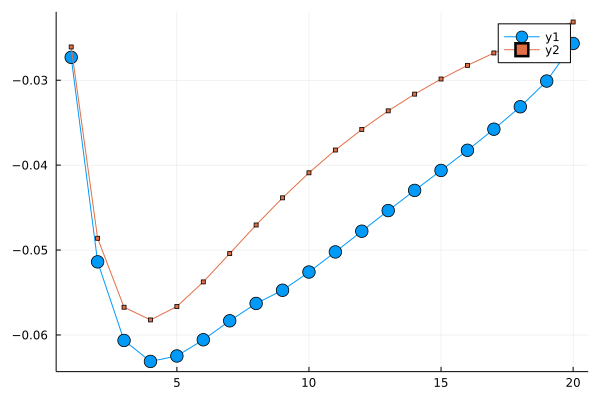

In [5]:
plot(imag(Σ_ladderLoc[1:20]), markershape=:auto, markersize=7)
plot!(imag(Σ_loc[1:20]), markershape=:auto, markersize=2)

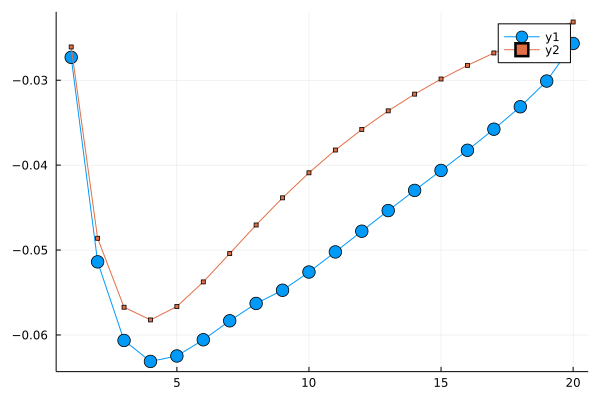

In [7]:
plot(imag(Σ_ladderLoc[1:20]), markershape=:auto, markersize=7)
plot!(imag(Σ_loc[1:20]), markershape=:auto, markersize=2)

# Preparation

For the extended $\lambda$ correction, we need to compute ladder kinetic and potential energy of the system and also compute the DMFT kinetic energy (for improved sums)

# Cond 1 Test
## λsp(λch)

In [6]:
χ_λ! = LadderDGA.χ_λ!
kintegrate = LadderDGA.kintegrate
sum_freq_full = LadderDGA.sum_freq_full
subtract_tail = LadderDGA.subtract_tail
ωindices = intersect(nlQ_sp.usable_ω, nlQ_ch.usable_ω)
iωn = 1im .* 2 .* (-sP.n_iω:sP.n_iω)[ωindices] .* π ./ mP.β
nh  = ceil(Int64, size(nlQ_sp_nλ.χ,2)/2)
χsp_min    = -minimum(1 ./ real.(nlQ_sp_nλ.χ[:,nh])) .+ 0.1
χch_min    = -minimum(1 ./ real.(nlQ_ch_nλ.χ[:,nh])) .+ 0.1

λch_range = χch_min:0.1:0.0
spOfch_max_nl = zeros(length(λch_range))

χsp_nλ_r = real.(deepcopy(nlQ_sp_nλ.χ[:,ωindices]))
χch_nλ_r = real.(deepcopy(nlQ_ch_nλ.χ[:,ωindices]))
χch_λ = similar(χch_nλ_r)

for (λi,λchi) in enumerate(λch_range)
    #χsp_λ = real.(deepcopy(nlQ_sp_nλ.χ[:,ωindices]))
    χ_λ!(χch_λ, χch_nλ_r, λchi)
    χch_ω = kintegrate(kG, χch_λ, 1)[1,:]
    χch_ω_sub = subtract_tail(χch_ω, mP.Ekin_DMFT, iωn)
    χch_sum = real(sum(χch_ω_sub))/mP.β - mP.Ekin_DMFT*mP.β/12
    rhs_val = (mP.n) * (1 - mP.n/2) - χch_sum
    λ = LadderDGA.λsp(χsp_nλ_r, iωn, mP.Ekin_DMFT, rhs_val, kG, mP)
    println("sum(χch) = $χch_sum => rhs = $rhs_val => λ = $λ")
    spOfch_max_nl[λi] = λ
end;

sum(χch) = 0.41955980176112867 => rhs = 0.08044019823887133 => λ = 10.228221566151113
sum(χch) = 0.3471501302415838 => rhs = 0.1528498697584162 => λ = 2.5467307344183525
sum(χch) = 0.31353766074020806 => rhs = 0.18646233925979194 => λ = 1.4435658256726684
sum(χch) = 0.291377721467694 => rhs = 0.20862227853230603 => λ = 0.9866183874614274
sum(χch) = 0.2746927599937398 => rhs = 0.22530724000626018 => λ = 0.7312866454006249
sum(χch) = 0.2612561773781981 => rhs = 0.23874382262180188 => λ = 0.5667528766719503
sum(χch) = 0.24999260458096936 => rhs = 0.2500073954190306 => λ = 0.45151544440047237
sum(χch) = 0.24029597121353288 => rhs = 0.25970402878646714 => λ = 0.3662594224197986
sum(χch) = 0.23178825848058152 => rhs = 0.2682117415194185 => λ = 0.3006817804353734
sum(χch) = 0.22421632196359678 => rhs = 0.27578367803640325 => λ = 0.248746200371207
sum(χch) = 0.2174015386448924 => rhs = 0.2825984613551076 => λ = 0.20666548273751983
sum(χch) = 0.21121272864800042 => rhs = 0.28878727135199955 => 

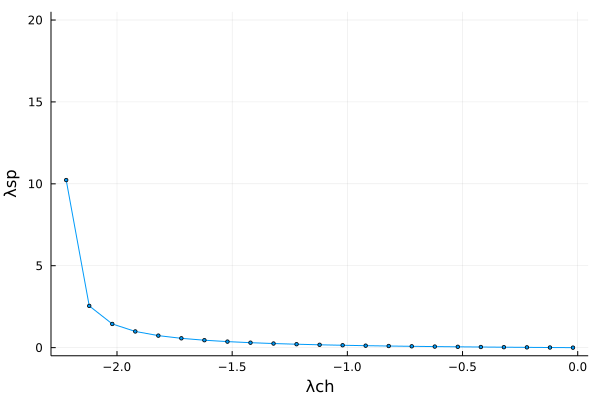

In [7]:
plot(λch_range, spOfch_max_nl, ylims=(-0.5,20.5), markershape=:circle, markersize=2, xlabel="λch", ylabel="λsp", label="")

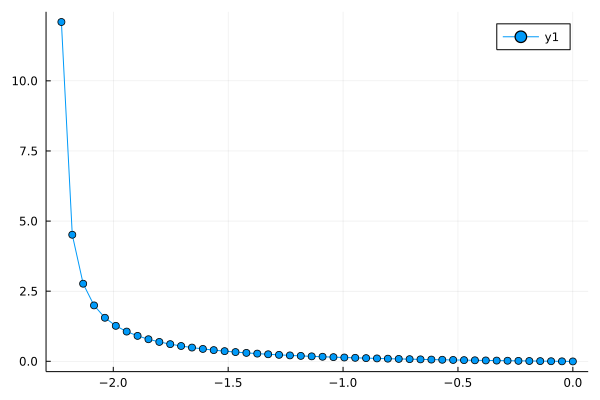

In [8]:
include("/home/julian/Hamburg/LadderDGA_utils.jl/new_lambda_analysis.jl")

λch_range_f,spOfch_f= λsp_of_λch(nlQ_sp_nλ, nlQ_ch_nλ, sP; λch_max=0.0, n_λch=50);
plot(λch_range_f,spOfch_f,markershape=:auto)

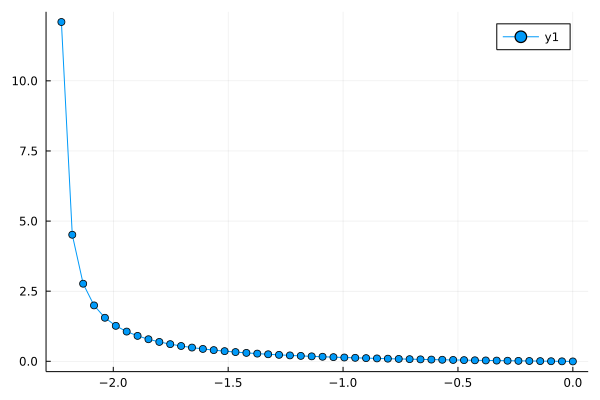

In [17]:
include("/home/julian/Hamburg/LadderDGA_utils.jl/new_lambda_analysis.jl")

λch_range_f,spOfch_f= λsp_of_λch(nlQ_sp_nλ, nlQ_ch_nλ, sP; λch_max=0.0, n_λch=50);
plot(λch_range_f,spOfch_f,markershape=:auto)

# cond2
## λsp(λch)

In [9]:
iν_array = LadderDGA.iν_array
calc_Σ_ω! = LadderDGA.calc_Σ_ω!
G_from_Σ = LadderDGA.G_from_Σ
flatten_2D = LadderDGA.flatten_2D
extend_corr! = LadderDGA.extend_corr!

nlQ_sp = deepcopy(nlQ_sp_nλ)
nlQ_ch = deepcopy(nlQ_ch_nλ)
Gνω = GLoc_fft

ωindices = (sP.dbg_full_eom_omega) ? (1:size(bubble,3)) : intersect(nlQ_sp.usable_ω, nlQ_ch.usable_ω)
iωn = 1im .* 2 .* (-sP.n_iω:sP.n_iω)[ωindices] .* π ./ mP.β

χupdo_ω = Array{eltype(nlQ_sp.χ),1}(undef, length(ωindices))
χupup_ω = Array{eltype(nlQ_sp.χ),1}(undef, length(ωindices))

# Prepare data
corr = Σ_correction(ωindices, bubble, FUpDo, sP)
(sP.tc_type_f != :nothing) && extend_corr!(corr)

νmax = trunc(Int,size(bubble,2)/3)
νG = 0:(νmax-1)
iν_n = iν_array(mP.β, νG)
Σ_hartree = mP.n * mP.U/2
E_kin_tail_c = [zeros(size(kG.ϵkGrid)), (kG.ϵkGrid .+ Σ_hartree .- mP.μ)]
E_pot_tail_c = [zeros(size(kG.ϵkGrid)),
                (mP.U^2 * 0.5 * mP.n * (1-0.5*mP.n) .+ Σ_hartree .* (kG.ϵkGrid .+ Σ_hartree .- mP.μ))]
tail = [1 ./ (iν_n .^ n) for n in 1:length(E_kin_tail_c)]
E_pot_tail = permutedims(sum(E_pot_tail_c[i]' .* tail[i] for i in 1:length(tail)),(2,1))
E_kin_tail = permutedims(sum(E_kin_tail_c[i]' .* tail[i] for i in 1:length(tail)),(2,1))
E_pot_tail_inv = sum((mP.β/2)  .* [Σ_hartree .* ones(size(kG.ϵkGrid)), (-mP.β/2) .* E_pot_tail_c[2]])
E_kin_tail_inv = sum(map(x->x .* (mP.β/2) .* kG.ϵkGrid , [1, -(mP.β) .* E_kin_tail_c[2]]));

In [10]:
gridshape = LadderDGA.gridshape
res = Array{Float64, 2}(undef, length(λch_range_f), 6)


nlQ_sp_i = deepcopy(nlQ_sp_nλ);
nlQ_ch_i = deepcopy(nlQ_ch_nλ);
Σ_list = Array{Complex{Float64},3}(undef, length(λch_range_f), length(Σ_ladderLoc), length(kG.kGrid))
nd = length(gridshape(kG))
G_λ = Array{ComplexF64, 2}(undef, length(kG.kMult), νmax)
Σ_corr =  Σ_loc[1:length(Σ_ladderLoc)] .- Σ_ladderLoc[:] .+ Σ_hartree
 

for i in 1:length(λch_range_f)
    print("\r$i of $(length(λch_range_f))")
    λsp_i = spOfch_f[i]
    λch_i = λch_range_f[i]
    LadderDGA.χ_λ!(nlQ_sp_i.χ, nlQ_sp_nλ.χ, λsp_i, ωindices)
    LadderDGA.χ_λ!(nlQ_ch_i.χ, nlQ_ch_nλ.χ, λch_i, ωindices)
    Σ_λ = calc_Σ(nlQ_sp_i, nlQ_ch_i, bubble, GLoc_fft, FUpDo, kG, mP, sP)[:,1:νmax]
    for qi in 1:size(Σ_λ, 1)
        view(Σ_λ, qi, :) = view(Σ_λ, qi, :) .+ Σ_corr
    end
    E3 = 0.0#E_pot_DGA_i[end][1]#LadderDGA.calc_E_pot(kG, GLoc[0:νmax-1,:].parent, Σ_λ, E_pot_tail, E_pot_tail_inv, mP.β)

    #G_λ = flatten_2D(G_from_Σ(Σ_λ, kG.ϵkGrid, 0:νmax-1, mP));
    for ni in 0:νmax-1
        for (j,ek) in enumerate(kG.ϵkGrid)
            G_λ[j,ni+1] = G_from_Σ(ni, mP.β, mP.μ, ek, Σ_λ[j,ni+1])
        end
    end
    E_pot = real.(G_λ .* Σ_λ .- E_pot_tail);
    E4 = LadderDGA.calc_E_pot(kG, G_λ, Σ_λ, E_pot_tail, E_pot_tail_inv, mP.β)
    
    for (wi,w) in enumerate(ωindices)
        χupup_ω[wi] = real(kintegrate(kG, nlQ_ch_i.χ[:,w] .+ nlQ_sp_i.χ[:,w])[1]) / 2
        χupdo_ω[wi] = real(kintegrate(kG, nlQ_ch_i.χ[:,w] .- nlQ_sp_i.χ[:,w])[1]) / 2
    end
    χupup_ω = subtract_tail(χupup_ω, mP.Ekin_DMFT, iωn)
    lhs_c1 = sum(χupup_ω)/mP.β - mP.Ekin_DMFT*mP.β/12
    lhs_c2 = sum(χupdo_ω)/mP.β
    rhs_c1 = mP.n/2 * (1 - mP.n/2)
    rhs_c2 = E3/mP.U - (mP.n/2) * (mP.n/2)
    rhs_c2_2 = E4/mP.U - (mP.n/2) * (mP.n/2)
    res[i,:] = [λsp_i λch_i lhs_c1 rhs_c1 lhs_c2 rhs_c2_2]
end

48 of 48

In [11]:

rr = c2_along_λsp_of_λch(λch_range_f, spOfch_f,nlQ_sp_nλ, nlQ_ch_nλ, bubble,
          Σ_ladderLoc, Σ_loc,GLoc_fft, FUpDo, kG,mP, sP);

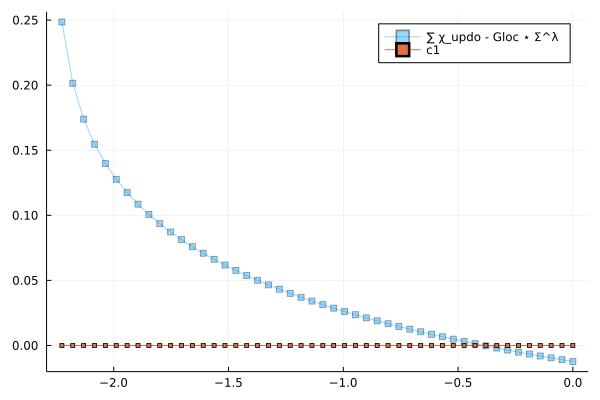

In [13]:
xarr = 1:length(λch_range_f)
#plot(λch_range[xarr], res[xarr,5] .- res[xarr,6], markershape=:square, markersize=2, label="∑ χ_updo - G^λ ⋆ Σ^λ")
plot(λch_range_f[xarr], rr[xarr,5] .- rr[xarr,6], markershape=:square, markersize=3, legend=:topright, alpha=0.4, label="∑ χ_updo - Gloc ⋆ Σ^λ")
plot!(λch_range_f[xarr],rr[xarr,3] .- rr[xarr,4], markershape=:square, markersize=2, label="c1")
#savefig("conditions_new.pdf")
#plot!(λch_range, spOfch_max_nl, ylims=(-5,5), markershape=:circle, markersize=2, xlabel="λch", ylabel="λsp", label="")

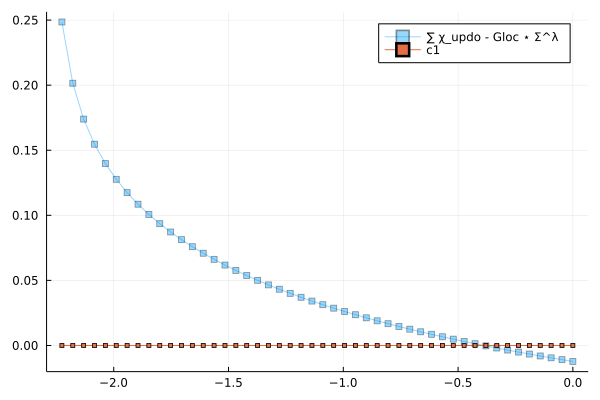

In [21]:
xarr = 1:length(λch_range_f)
#plot(λch_range[xarr], res[xarr,5] .- res[xarr,6], markershape=:square, markersize=2, label="∑ χ_updo - G^λ ⋆ Σ^λ")
plot(λch_range_f[xarr], rr[xarr,5] .- rr[xarr,6], markershape=:square, markersize=3, legend=:topright, alpha=0.4, label="∑ χ_updo - Gloc ⋆ Σ^λ")
plot!(λch_range_f[xarr],rr[xarr,3] .- rr[xarr,4], markershape=:square, markersize=2, label="c1")
#savefig("conditions_new.pdf")
#plot!(λch_range, spOfch_max_nl, ylims=(-5,5), markershape=:circle, markersize=2, xlabel="λch", ylabel="λsp", label="")

In [22]:
using Dispersions

χ_λ! = LadderDGA.χ_λ!
ν0Index_of_ωIndex = LadderDGA.ν0Index_of_ωIndex
conv_fft1 = LadderDGA.conv_fft1
kintegrate = LadderDGA.kintegrate
subtract_tail! = LadderDGA.subtract_tail!
expandKArr = LadderDGA.expandKArr
expandKArr! = LadderDGA.expandKArr!
reduceKArr = LadderDGA.reduceKArr
fft = LadderDGA.fft
ifft = LadderDGA.ifft
fft! = LadderDGA.fft!
ifft! = LadderDGA.ifft!
iν_array = LadderDGA.iν_array
extend_tmp! = LadderDGA.extend_corr!
G_from_Σ = LadderDGA.G_from_Σ
Gνω = GLoc_fft
q_axis = LadderDGA.q_axis
ν_axis = LadderDGA.ν_axis

ωindices = (sP.dbg_full_eom_omega) ? (1:size(bubble,1)) : intersect(nlQ_sp.usable_ω, nlQ_ch.usable_ω)


νmax = trunc(Int,size(bubble,2)/3)
νGrid = 0:(νmax-1)
iν_n = iν_array(mP.β, νGrid)
iωn = 1im .* 2 .* (-sP.n_iω:sP.n_iω)[ωindices] .* π ./ mP.β
iωn2_sub = real.([i == 0 ? 0 : mP.Ekin_DMFT ./ (i).^2 for i in iωn])

Σ_ladder_i = Array{Complex{Float64},2}(undef, size(bubble,1), νmax)
χupdo_ω = Array{eltype(nlQ_sp.χ),1}(undef, length(ωindices))
χupup_ω = Array{eltype(nlQ_sp.χ),1}(undef, length(ωindices))
χsp_int2 = Array{eltype(nlQ_sp.χ),2}(undef, size(nlQ_sp.χ)...)
χch_int2 = Array{eltype(nlQ_sp.χ),2}(undef, size(nlQ_sp.χ)...)


# Prepare data
corr = Σ_correction(ωindices, bubble, FUpDo, sP)
(sP.tc_type_f != :nothing) && extend_corr!(corr)

nh    = ceil(Int64, size(nlQ_sp.χ,1)/2)
χsp_min    = -1 / maximum(real.(nlQ_sp.χ[nh,:]))
χch_min    = -1 / maximum(real.(nlQ_ch.χ[nh,:]))


Σ_hartree = mP.n * mP.U/2
E_kin_tail_c = [zeros(size(kG.ϵkGrid)), (kG.ϵkGrid .+ Σ_hartree .- mP.μ)]
E_pot_tail_c = [zeros(size(kG.ϵkGrid)),
                (mP.U^2 * 0.5 * mP.n * (1-0.5*mP.n) .+ Σ_hartree .* (kG.ϵkGrid .+ Σ_hartree .- mP.μ))]
tail = [1 ./ (iν_n .^ n) for n in 1:length(E_kin_tail_c)]
E_pot_tail = permutedims(sum(E_pot_tail_c[i]' .* tail[i] for i in 1:length(tail)),(2,1))
E_pot_tail_inv = sum((mP.β/2)  .* [Σ_hartree .* ones(size(kG.ϵkGrid)), (-mP.β/2) .* E_pot_tail_c[2]]);

In [23]:
ωindices = (sP.dbg_full_eom_omega) ? (1:size(bubble,1)) : intersect(nlQ_sp.usable_ω, nlQ_ch.usable_ω)

νmax = trunc(Int,size(bubble,2)/3)
Kνωq = Array{ComplexF64, length(gridshape(kG))}(undef, gridshape(kG)...)
Kνωq_pre = Array{ComplexF64, 1}(undef, size(corr,q_axis))


nd = length(gridshape(kG))
Σ_corr =  Σ_loc[1:length(Σ_ladderLoc)] .- Σ_ladderLoc[:] .+ Σ_hartree

function cond_both!(F, λ)
    lhs_c1 = 0.0
    lhs_c2 = 0.0
    
    nd = length(gridshape(kG))
    fill!(Σ_ladder_i, zero(eltype(Σ_ladder_i)))

    for ωii in 1:length(ωindices)
        ωi = ωindices[ωii]
        ωn = (ωi - sP.n_iω) - 1
    
        @inbounds fsp = 1.5 .* (1 .+ mP.U .* view(nlQ_sp.χ,:,ωi))
        @inbounds fch = 0.5 .* (1 .- mP.U .* view(nlQ_ch.χ,:,ωi))
        νZero = ν0Index_of_ωIndex(ωi, sP)
        maxn = minimum([νZero + νmax - 1, size(nlQ_ch.γ,ν_axis)])
        for (νi,νn) in enumerate(νZero:maxn)
            @simd for qi in 1:size(corr,q_axis)
                @inbounds Kνωq_pre[qi] = nlQ_sp.γ[qi,νn,ωi] * fsp[qi] - nlQ_ch.γ[qi,νn,ωi] * fch[qi] - 1.5 + 0.5 + corr[qi,νn,ωii]
            end
            expandKArr!(kG,Kνωq,Kνωq_pre)
            Dispersions.mul!(Kνωq, kG.fftw_plan, Kνωq)
            v = selectdim(Gνω,nd+1,(νi-1) + ωn + sP.fft_offset)
            @simd for ki in 1:length(Kνωq)
                @inbounds Kνωq[ki] *= v[ki]
            end
            Dispersions.ldiv!(Kνωq, kG.fftw_plan, Kνωq)
            Dispersions.ifft_post!(typeof(kG), Kνωq)
            reduceKArr!(kG, Kνωq_pre, Kνωq) 
            @simd for i in 1:size(corr,q_axis)
                @inbounds Σ_ladder_i[i,νi] += Kνωq_pre[i]/kG.Nk
            end
        end
        #TODO: end manual unroll of conv_fft1
        #@inbounds conv_fft!(kG, view(Σ,:,νn,ωii), Gνω[(νn-1) + ωn + sP.fft_offset], Kνωq)

        t1 = 0.0
        t2 = 0.0
        for qi in 1:length(kG.kMult)
            t1 += kG.kMult[qi]*real( 1.0 / ((1.0 / nlQ_ch.χ[qi,ωi]) .+ λ[2]))
            t2 += kG.kMult[qi]*real( 1.0 / ((1.0 / nlQ_sp.χ[qi,ωi]) .+ λ[1]))
        end
        lhs_c1 += (t1 + t2) / (2*kG.Nk) - iωn2_sub[ωii]
        lhs_c2 += (t1 - t2) / (2*kG.Nk)
        
    end
    E_pot = 0.0
    for qi in 1:length(kG.kMult)
        GΣ_λ = 0.0
        for i in 1:νmax
            Σ_λ = mP.U * Σ_ladder_i[qi,i]/mP.β + Σ_corr[i]
            GΣ_λ += 2 * real(Σ_λ * G_from_Σ(iν_n[i], mP.β, mP.μ, kG.ϵkGrid[qi], Σ_λ) - E_pot_tail[qi,i])
        end
        GΣ_λ += E_pot_tail_inv[qi]   # ν summation
        E_pot += kG.kMult[qi]*GΣ_λ # k intgration
    end
    E_pot = E_pot / (kG.Nk * mP.β)
    lhs_c1 = (lhs_c1 - mP.Ekin_DMFT*mP.β/12)/mP.β
    lhs_c2 = lhs_c2/mP.β

    rhs_c1 = mP.n/2 * (1 - mP.n/2)
    rhs_c2 = E_pot/mP.U - (mP.n/2) * (mP.n/2)
    F[1] = lhs_c1 - rhs_c1
    F[2] = lhs_c2 - rhs_c2
    return F
end

cond_both! (generic function with 1 method)

In [24]:
Σ_ladderLoc = reshape(Σ_ladderLoc, (1,20))

1×20 Matrix{ComplexF64}:
 0.5-0.0273065im  0.5-0.0513894im  …  0.5-0.0301004im  0.5-0.0256754im

In [25]:
λsp_old = λ_correction(:sp_ch, impQ_sp, impQ_ch, FUpDo, Σ_loc, Σ_ladderLoc, nlQ_sp, nlQ_ch,bubble, GLoc_fft, kG, mP, sP)

LoadError: MethodError: no method matching extended_λ(::NonLocalQuantities, ::NonLocalQuantities, ::Array{Float64, 3}, ::Array{ComplexF64, 4}, ::Array{Float64, 3}, ::Vector{ComplexF64}, ::Matrix{ComplexF64}, ::Dispersions.ReducedKGrid_cP{3}, ::ModelParameters, ::SimulationParameters)
[0mClosest candidates are:
[0m  extended_λ(::NonLocalQuantities, ::NonLocalQuantities, ::Array{Float64, 3}, ::Array, [91m::AbstractArray{ComplexF64, 3}[39m, ::AbstractVector{ComplexF64}, ::AbstractMatrix{ComplexF64}, ::ReducedKGrid, ::ModelParameters, ::SimulationParameters) at /home/julian/Hamburg/LadderDGA.jl/src/lambdaCorrection.jl:80

In [26]:
f1 = [1.0 3.1]
f2 = [1.0 3.1]
λttt = [0.1 3.2]
#@time cond_both_old!(f1, λttt)
@time cond_both!(f2, λttt)
println("$f1 vs $f2 <=> $(f1 ≈ f2)")

  0.893384 seconds (1.16 M allocations: 77.649 MiB, 3.04% gc time, 99.25% compilation time)
[1.0 3.1] vs [-0.041632350320677386 -0.01415968200091218] <=> false


In [27]:
using FiniteDiff
using LinearAlgebra

function newton_2d_right(f::Function, 
                start::Vector{Float64}; nsteps=20, atol=1e-6)
    done = false
    trace = Array{Float64, 2}(undef, 6, nsteps)
    δ = [0.1, 0.1]
    x0 = start .+ δ
    xi = x0
    i = 1
    cache = FiniteDiff.JacobianCache(xi)
    J2 = Matrix{Float64}(undef, 2,2)
    while !done
        fi = f(xi)
        dfii = inv(FiniteDiff.finite_difference_jacobian(f, xi, cache))
        xlast = xi
        xi = x0 - dfii * fi
        (norm(xi-x0) < atol) && break
        trace[:,i] = [x0... xi... δ...]
        #TODO: additional requirements: too far right?
        if xi[2] > 0.0       # λch has some cutoff value, here just 0, later to be determined
            #println("case 1: reset $δ to $(2 ./ δ)")
            #flush(stdout)
            δ  = δ ./ 2 
            x0 = start .+ δ      # reset with smaller delta
            xi = x0
        elseif any(xi .< x0)         # only ever search to the right!
            #println("case 2: reset $δ to $(2 .* δ)")
            #flush(stdout)
            δ  = 1.5 .* δ
            x0 = start .+ δ      # reset with larger delta
            xi = x0
        else
            x0 = xi
        end
        (i >= nsteps ) && (done = true)
        i += 1
    end
    return xi, trace
end

newton_2d_right (generic function with 1 method)

In [28]:
x0 = [1.0, χch_min+0.0]

r,tt = newton_2d_right(cond_both, x0, nsteps=10, atol=1e-6)

LoadError: UndefVarError: cond_both not defined

In [29]:
scatter(tt[1,:]', label="x0")

LoadError: UndefVarError: tt not defined

In [32]:
@time r = LadderDGA.extended_λ(nlQ_sp_nλ, nlQ_ch_nλ, bubble, GLoc_fft, FUpDo, Σ_loc, Σ_ladderLoc, kG, mP, sP)

LoadError: MethodError: no method matching extended_λ(::NonLocalQuantities, ::NonLocalQuantities, ::Array{Float64, 3}, ::Array{ComplexF64, 4}, ::Array{Float64, 3}, ::Vector{ComplexF64}, ::Matrix{ComplexF64}, ::Dispersions.ReducedKGrid_cP{3}, ::ModelParameters, ::SimulationParameters)
[0mClosest candidates are:
[0m  extended_λ(::NonLocalQuantities, ::NonLocalQuantities, ::Array{Float64, 3}, ::Array, [91m::AbstractArray{ComplexF64, 3}[39m, ::AbstractVector{ComplexF64}, ::AbstractMatrix{ComplexF64}, ::ReducedKGrid, ::ModelParameters, ::SimulationParameters) at /home/julian/Hamburg/LadderDGA.jl/src/lambdaCorrection.jl:80

In [33]:
Σ_λ = Σ_ladder_corrected[1:νmax,:]
#Σ_λ = (Σ_ladder_i .- Σ_ladderLoc[1:size(Σ_ladder_i,1)] .+ Σ_loc[1:size(Σ_ladder_i,1)]);
E_kin_DGA, E_pot_DGA_i = LadderDGA.calc_E(Σ_λ, kGrid, mP, sP)
#E3 = LadderDGA.calc_E_pot(kG, GLoc[0:νmax-1,:].parent, Σ_λ, E_pot_tail, E_pot_tail_inv, mP.β)
Σ_λ .= Σ_λ .+ Σ_hartree
G_λ = flatten_2D(G_from_Σ(Σ_λ, kG.ϵkGrid, 0:νmax-1, mP));
E3_h = real.(G_λ .* Σ_λ .- E_pot_tail);
E3 = kintegrate(kG, 2 .* sum(E3_h[1:size(Σ_λ,1),:], dims=[1])[1,:] .+ E_pot_tail_inv)[1] / mP.β
E4 = LadderDGA.calc_E_pot(kG, G_λ, Σ_λ, E_pot_tail, E_pot_tail_inv, mP.β);

LoadError: BoundsError: attempt to access 4×20 Matrix{ComplexF64} at index [1:13, 1:20]

In [34]:
ep1 = map(x-> x[1], E_pot_DGA_i)
ep2 = map(x-> x[1], E3)
ep3 = map(x-> x[1], E4)
plot(ep1,markershape=:auto, markersize=6, label="full")
hline!([E3], label="fast 1")
hline!([E4], label="fast")

LoadError: UndefVarError: E_pot_DGA_i not defined

322.476980 seconds (1.13 G allocations: 254.027 GiB, 16.14% gc time, 0.06% compilation time)


# extended Lambda test
TODO: reactivate plots

In [35]:
mP = LadderDGA.modelParams
sP = LadderDGA.simParams
nc = [0,1,2,3]
NW = floor(Int64, length(usable_ω)/2)
ωmin = 1
ωmax = NW 
coeffs = collect(0:3)
Wω = LadderDGA.build_weights(ωmin, ωmax, coeffs)
println("building  weight matrix from $ωmin to $ωmax with coefficients $(coeffs)")
include("src/ConvergenceAcc.jl")
#Shanks.shanks(E_Pot, csum_inp=true) 

testf_c2(λspi , λchi) = LadderDGA.calc_E_pot_cond(λspi , λchi, nlQ_sp, nlQ_ch, bubble, 
                         LadderDGA.ϵkGrid, LadderDGA.FUpDo, 
                         LadderDGA.Σ_loc_pos,Σ_ladderLoc,
                         LadderDGA.qIndices, LadderDGA.qMultiplicity, 
                         mP, sP, sP.tail_corrected);
function cond_both_nc!(F, λ)
    testf!(λ) = construct_f(λ[1],λchi, rχsp, rχch, mode=m, rhs=rhs_val)
    testdf!(λ) = construct_df(λ[1], λchi, rχsp, rχch, mode=m, rhs=rhs_val);
    Σ_ladder2, lhs_c2, E_pot_DGA = testf_c2(λ[1], λ[2])
    χsp_λ = LadderDGA.χ_λ(real.(nlQ_sp.χ), λ[1])
    χch_λ = LadderDGA.χ_λ(real.(nlQ_ch.χ), λ[2])
    χupup = LadderDGA.sum_q(χch_λ[usable_ω,:].+ χsp_λ[usable_ω,:], LadderDGA.qMultiplicity, dims=2)[:,1] ./ 2
    nwh = ceil(Int64, size(χsp_λ,1)/2)
    penalty = sum(abs.(χsp_λ[nwh,(χsp_λ[nwh,:] .< 0)])) + sum(abs.(χch_λ[nwh,(χch_λ[nwh,:] .< 0)])) 
    #penalty2 = length(χch_λ[nwh,((χch_λ[nwh,:] .< 0.01) .& (χch_λ[nwh,:] .>= 0.0))])
    tmp =  real(LadderDGA.sum_freq(χupup, [1], true, mP.β, weights=Wω)[1]) 
    #tmp += -penalty
    lhs_c1 = (mP.n/2) * (1 - mP.n/2)
    println("calling for λ=$λ, E_pot=$(E_pot_DGA), penalty = $penalty")
    F[1] = penalty > 0 ? penalty : tmp - lhs_c1
    F[2] = (lhs_c2) - E_pot_DGA# - penalty
end

function cond_both_c!(F, λ)
    Σ_ladder2, lhs_c2, E_pot_DGA = LadderDGA.calc_E_pot_cond(λ[1], λ[2], nlQ_sp, nlQ_ch, bubble, 
                     LadderDGA.ϵkGrid, LadderDGA.FUpDo, 
                     LadderDGA.Σ_loc_pos,Σ_ladderLoc,
                     LadderDGA.qIndices, LadderDGA.qMultiplicity, 
                     mP, sP, sP.tail_corrected, E_pot_tail_corr=true);
    χsp_λ = LadderDGA.χ_λ(real.(nlQ_sp.χ), λ[1])
    χch_λ = LadderDGA.χ_λ(real.(nlQ_ch.χ), λ[2])
    χupup = LadderDGA.sum_q(χch_λ[usable_ω,:].+ χsp_λ[usable_ω,:], LadderDGA.qMultiplicity, dims=2)[:,1] ./ 2
    nwh = ceil(Int64, size(χsp_λ,1)/2)
    penalty = sum(abs.(χsp_λ[nwh,(χsp_λ[nwh,:] .< 0)])) + sum(abs.(χch_λ[nwh,(χch_λ[nwh,:] .< 0)])) 
    #penalty2 = length(χch_λ[nwh,((χch_λ[nwh,:] .< 0.01) .& (χch_λ[nwh,:] .>= 0.0))])
    tmp =  real(LadderDGA.sum_freq(χupup, [1], true, mP.β, weights=Wω)[1]) 
    #tmp += -penalty
    lhs_c1 = mP.n/2 * (1 - mP.n/2)
    println("calling for λ=$(round.(λ,digits=2)), E_pot=$(E_pot_DGA), res = $(abs(tmp - lhs_c1) + abs(E_pot_DGA + (lhs_c2))), penalty = $penalty")
    F[1] = penalty > 0 ? penalty : tmp - lhs_c1
    F[2] = (lhs_c2) - E_pot_DGA
    #F[3] = mP.n - sum(Gμλ)
end

LoadError: UndefVarError: modelParams not defined

In [36]:
using LaTeXStrings
χsp_λ = LadderDGA.χ_λ(real.(nlQ_sp.χ[usable_ω,:]), res_nc.zero[1])
χch_λ = LadderDGA.χ_λ(real.(nlQ_ch.χ[usable_ω,:]), res_nc.zero[2])
χupup = LadderDGA.sum_q(χch_λ .+ χsp_λ, LadderDGA.qMultiplicity, dims=2)[:,1] ./ 2
χupdo = LadderDGA.sum_q(χch_λ .- χsp_λ, LadderDGA.qMultiplicity, dims=2)[:,1] ./ 2
rhs_c1 = real(LadderDGA.sum_freq(χupup, [1], true, mP.β, weights=Wω)[1])  
rhs_c2 = mP.U * real(LadderDGA.sum_freq(χupdo, [1], true, mP.β, weights=Wω)[1])  + mP.n^2/4
lhs_c1 = mP.n/2 * (1 - mP.n/2)
Σ_ladder2, lhs_c2, E_pot_DGA = LadderDGA.calc_E_pot_cond(res_nc.zero[1], res_nc.zero[2], nlQ_sp, nlQ_ch, bubble, 
                     LadderDGA.ϵkGrid, LadderDGA.FUpDo, 
                     LadderDGA.Σ_loc_pos,Σ_ladderLoc,
                     LadderDGA.qIndices, LadderDGA.qMultiplicity, 
                     mP, sP, sP.tail_corrected, E_pot_tail_corr=false);
E_Kin, E_Pot = LadderDGA.calc_E(Σ_ladder2, LadderDGA.ϵqGrid, LadderDGA.qMultiplicity, sP.Nk, mP, sP);


l = @layout [A{0.01h}; 
             [grid(1,2)
              b{0.3h}]]
nhi = 20
xarr = usable_ω .- ceil(Int64, size(bubble,1)/2)
title = plot(title = L"U=%$(mP.U), \beta=%$(mP.β)", grid = false, showaxis = false, bottom_margin = -50Plots.px)
p1 = plot(xarr, χsp_λ[:,1], legend = true, xlabel=L"\omega_n", ylabel=L"\chi^\lambda_{\mathrm{sp}}", label="q=$(round.(LadderDGA.qGrid[1],digits=2))", markershape=:circle, markersize=2)
plot!(xarr, χsp_λ[:,nhi], label="q=$(round.(LadderDGA.qGrid[nhi],digits=2))", markershape=:circle, markersize=2)
plot!(xarr, χsp_λ[:,end], label="q=$(round.(LadderDGA.qGrid[end],digits=2))", markershape=:circle, markersize=2)
annotate_y_pos = 0.7*maximum([maximum(χsp_λ[:,1]), maximum(χsp_λ[:,nhi]), maximum(χsp_λ[:,end])])
annotate!(xarr[end-2], annotate_y_pos, text(L"\lambda_\mathrm{sp} = %$(round(res_nc.zero[1],digits=3))", :right, 10))

    
p2 = plot(xarr, χch_λ[:,1], legend = false, xlabel=L"\omega_n", ylabel=L"\chi^\lambda_{\mathrm{ch}}", label="q=$(round.(LadderDGA.qGrid[1],digits=2))", markershape=:hexagon, markersize=2)
plot!(xarr, χch_λ[:,nhi], label="q=$(round.(LadderDGA.qGrid[nhi],digits=2))", markershape=:hexagon, markersize=2)
plot!(xarr, χch_λ[:,end], label="q=$(round.(LadderDGA.qGrid[end],digits=2))", markershape=:hexagon, markersize=2)
annotate_y_pos = 0.75*maximum([maximum(χch_λ[:,1]), maximum(χch_λ[:,nhi]), maximum(χch_λ[:,end])])
annotate!(xarr[end-2], annotate_y_pos, text(L"\lambda_\mathrm{ch} = %$(round(res_nc.zero[2],digits=3))", :right, 10))


p3 = plot(E_Pot, xlabel=L"\nu_n", label=L"\qquad\qquad\;\;\; G^\lambda \star \Sigma^\lambda = %$(round(E_Pot[end], digits=6))", markershape=:hexagon, markersize=2,legend=:bottomright, legendfontsize=9)
plot!([rhs_c2], seriestype = :hline, label=L"\frac{1}{\beta N_k} \sum_{\omega,q} \chi_\mathrm{up, do}\quad\, = %$(round(rhs_c2, digits=6))")
plot!([E_Pot[end]], seriestype = :hline, linestyle=:dash, label=L"\mathrm{\;\;\;naive\;E}_\mathrm{pot, LDGA} = %$(round(E_pot_DGA, digits=6))")
annotate_y_pos = (0.3*(maximum(E_Pot) - minimum(E_Pot)) + minimum(E_Pot))
annotate!(0.2*length(E_Pot), annotate_y_pos, text(L"\frac{1}{\beta N_k}\sum_{\omega,q} \chi_\mathrm{up, up} = %$(round(rhs_c1,digits=14)) \stackrel{!}{=} \frac{n}{2} (1-\frac{n}{2}) = %$(mP.n/2 *(1 - mP.n/2))", :left, 10))

plot(title, p1, p2, p3, layout = l, size=(1000,800))
#savefig("cond_solution_tc_test_b15U2.pdf")

LoadError: UndefVarError: usable_ω not defined

In [37]:
using LaTeXStrings

χsp_λ = LadderDGA.χ_λ(real.(nlQ_sp.χ[usable_ω,:]), res_nc.zero[1])
χch_λ = LadderDGA.χ_λ(real.(nlQ_ch.χ[usable_ω,:]), res_nc.zero[2])
χsp_λ_old = LadderDGA.χ_λ(real.(nlQ_sp.χ[usable_ω,:]),0.050817859568877091)
χch_λ_old = LadderDGA.χ_λ(real.(nlQ_ch.χ[usable_ω,:]), 0.0)
χupup = LadderDGA.sum_q(χch_λ .+ χsp_λ, LadderDGA.qMultiplicity, dims=2)[:,1] ./ 2
χupdo = LadderDGA.sum_q(χch_λ .- χsp_λ, LadderDGA.qMultiplicity, dims=2)[:,1] ./ 2
rhs_c1 = real(LadderDGA.sum_freq(χupup, [1], true, mP.β, weights=Wω)[1])  
rhs_c2 = mP.U * real(LadderDGA.sum_freq(χupdo, [1], true, mP.β, weights=Wω)[1])  + mP.n^2/4
lhs_c1 = mP.n/2 * (1 - mP.n/2)
Σ_ladder2, lhs_c2, E_pot_DGA = LadderDGA.calc_E_pot_cond(res_nc.zero[1], res_nc.zero[2], nlQ_sp, nlQ_ch, bubble, 
                     LadderDGA.ϵkGrid, LadderDGA.FUpDo, 
                     LadderDGA.Σ_loc_pos,Σ_ladderLoc,
                     LadderDGA.qIndices, LadderDGA.qMultiplicity, 
                     mP, sP, sP.tail_corrected, E_pot_tail_corr=false);
E_Kin, E_Pot = LadderDGA.calc_E(Σ_ladder2, LadderDGA.ϵqGrid, LadderDGA.qMultiplicity, sP.Nk, mP, sP);
E_Kin_naive, E_Pot_naive = calc_E_notail(Σ_ladder2, LadderDGA.ϵqGrid, LadderDGA.qMultiplicity, sP.Nk, mP, sP);
l = @layout [A{0.025h}; 
             grid(1,2)]
nhi = 20
xarr = usable_ω .- ceil(Int64, size(bubble,1)/2)
title = plot(title = L"U=%$(mP.U), \beta=%$(mP.β)", grid = false, showaxis = false, bottom_margin = -50Plots.px, titlefontsize=18)
p1 = plot(xarr, χsp_λ_old[:,end], label=L"\mathrm{Old\;Method:}\;\; \lambda_\mathrm{sp} = 0.051", markershape=:circle, markersize=3, markerstrokewidth=0.6)
plot!(xarr, χsp_λ[:,end], color=:orange, legend = :outertop, xlabel=L"\omega_n", ylabel=L"\chi^\lambda_{\mathrm{sp}}", label=L"\mathrm{New\;Method:}\; \lambda_\mathrm{sp} = %$(round(res_nc.zero[1],digits=3))", markershape=:hexagon, markerstrokewidth=0.6, markersize=3,
    xtickfontsize=12,ytickfontsize=12,legendfontsize=12,xguidefontsize=16,yguidefontsize=16, margin=4Plots.mm)
#plot!(xarr, χsp_λ[:,nhi], label="q=$(round.(LadderDGA.qGrid[nhi],digits=2))", markershape=:circle, markersize=2)
#p1 = plot(xarr, χsp_λ[:,end], label=L"q=$(\pi,\pi,\pi)", markershape=:circle, markersize=2)
annotate_y_pos = 0.7*maximum([maximum(χsp_λ[:,1]), maximum(χsp_λ[:,nhi]), maximum(χsp_λ[:,end])])
#annotate!(xarr[end-2], annotate_y_pos, text(L"\lambda_\mathrm{sp} = %$(round(res_nc.zero[1],digits=3))", :right, 10))
annotate!(xarr[end-2], annotate_y_pos, text(L"\vec{q}=(\pi,\pi,\pi)", :right, 16))
    
p2 = plot(xarr, χch_λ_old[:,end], label=L"\mathrm{Old\;Method:}\;\; \lambda_\mathrm{ch} = 0", markershape=:circle, markersize=3, markerstrokewidth=0.6)
plot!(xarr, χch_λ[:,end], color=:orange, legend = :outertop, xlabel=L"\omega_n", ylabel=L"\chi^\lambda_{\mathrm{ch}}", label=L"\mathrm{New\;Method:}\; \lambda_\mathrm{ch} = %$(round(res_nc.zero[2],digits=3))", markershape=:hexagon, markersize=3, markerstrokewidth=0.6,xtickfontsize=12,ytickfontsize=12,legendfontsize=12,xguidefontsize=16,yguidefontsize=16)
#plot!(xarr, χch_λ[:,nhi], label="q=$(round.(LadderDGA.qGrid[nhi],digits=2))", markershape=:hexagon, markersize=2)
#plot!(xarr, χch_λ[:,end], label="q=$(round.(LadderDGA.qGrid[end],digits=2))", markershape=:hexagon, markersize=2)
annotate_y_pos = 0.75*maximum([maximum(χch_λ[:,1]), maximum(χch_λ[:,nhi]), maximum(χch_λ[:,end])])
#annotate!(xarr[end-2], annotate_y_pos, text(L"\lambda_\mathrm{ch} = %$(round(res_nc.zero[2],digits=3))", :right, 10))
annotate!(xarr[end-2], annotate_y_pos, text(L"\vec{q}=(\pi,\pi,\pi)", :right, 16))



plot(title, p1, p2, layout = l, size=(1200,600))
#savefig("cond_solution_tc_test_b25U1.pdf")

LoadError: UndefVarError: usable_ω not defined

In [38]:
l2 = @layout [A{0.025h}; 
             grid(2,1)]

t = [real(mP.U * real(LadderDGA.sum_freq(χupdo[i+1:(end-i)], [1], true, mP.β, weights=LadderDGA.build_weights(1, floor(Int64, size(χupup[i+1:(end-i)], 1)/2), collect(0:3)))[1])  + mP.n^2/4) for i in 8:-1:0]

nanline = repeat([NaN], length(E_Pot))
p3 = plot(E_Pot_naive, xlabel=L"\nu_\mathrm{max}", 
    label=L"\;\;\;\frac{1}{\beta N_k}\sum_{\nu,q} G^\lambda \star \Sigma^\lambda\, = %$(round(E_Pot_naive[end], digits=6))",
    markershape=:hexagon, markersize=2, markerstrokewidth=0.4,legend=:bottomright, margin=1Plots.mm,
    xtickfontsize=12,ytickfontsize=12, legendfontsize=12,xguidefontsize=16,yguidefontsize=16)
plot!(nanline, label=" ", alpha= 0.0)
#[rhs_c2], seriestype = :hline
plot!(nh-9:nh-1,t,markershape=:hexagon, color=:orange, markersize=4, markerstrokewidth=0.4, label=L"\quad\;\mathrm{SumFit}_{\omega}[\chi_\mathrm{up, do}] = %$(round(rhs_c2, digits=6))")
plot!([rhs_c2], seriestype = :hline, label=nothing, color=:orange)
plot!(nanline, label=" ", alpha= 0.0)
plot!([E_Pot], markershape=:hexagon, markersize=2, markerstrokewidth=0.4, 
    label=L"{\mathrm{SumFit}_{\nu}[G^\lambda \star \Sigma^\lambda]\, = %$(round(E_Pot[end], digits=6))}")

naive_chiupup_sum = (χupup[nh] .+ 2 .* cumsum(χupup[nh+1:end])) ./ mP.β
tt = [real(LadderDGA.sum_freq(χupup[i+1:(end-i)], [1], true, mP.β, weights=LadderDGA.build_weights(1, floor(Int64, size(χupup[i+1:(end-i)], 1)/2), collect(0:3)))[1]) for i in 8:-1:0]
real(LadderDGA.sum_freq(χupup, [1], true, mP.β, weights=Wω)[1]) 

nanline = repeat([NaN], length(tt))
p4 = plot(1:nh-1,naive_chiupup_sum, xlabel=L"\omega_\mathrm{max}", 
    label=L"\;\;\;\frac{1}{\beta N_k}\sum_{\omega,q} \chi_\mathrm{up, up} =   %$(round(naive_chiupup_sum[end],digits=4))", xticks=collect(1:nh-1), margin=5Plots.mm,
    markershape=:hexagon, markersize=2, markerstrokewidth=0.4,legend=:bottomright,xtickfontsize=12,ytickfontsize=12, legendfontsize=12,xguidefontsize=16,yguidefontsize=16)
plot!(nanline, label=" ", alpha= 0.0)
plot!(nh-9:nh-1,tt,markershape=:hexagon, markersize=2, markerstrokewidth=0.4, color=:orange, label=L"\mathrm{SumFit}_{\omega}[\chi_\mathrm{up, up}] = %$(round(rhs_c1,digits=4))")
plot!(nanline, label=" ", alpha= 0.0)

plot!([0.25], seriestype = :hline, color=:green, label=L"\qquad\;\frac{n}{2}\left({1-\frac{n}{2}}\right) = \frac{1}{4}")
annotate_y_pos = (0.08*(maximum(χupup) - minimum(χupup)) + minimum(χupup))
#annotate!(0.3*length(1:nh-1), annotate_y_pos, text(L"\frac{1}{\beta N_k}\sum_{\omega,q} \chi_\mathrm{up, up} = %$(round(rhs_c1,digits=12)) \stackrel{!}{=} \frac{n}{2} (1-\frac{n}{2}) = %$(mP.n/2 *(1 - mP.n/2))", :left, 14))

plot(title, p3, p4, layout = l2, size=(1200,600))
#savefig("cond_solution_tc_test_b25U1_2.pdf")

LoadError: UndefVarError: χupdo not defined

In [39]:
using LaTeXStrings
usable_ω = ωindices
lsp_zero = 0.04856121321074435#res_c.zero[1]
lch_zero = 0.1292099471786603#res_c.zero[2]
χsp_λ = LadderDGA.χ_λ(real.(nlQ_sp.χ[usable_ω,:]), lsp_zero)
χch_λ = LadderDGA.χ_λ(real.(nlQ_ch.χ[usable_ω,:]), lch_zero)
χupup = LadderDGA.kintegrate(qG, χch_λ .+ χsp_λ, dim=2)[:,1] ./ 2
χupdo = LadderDGA.kintegrate(qG, χch_λ .- χsp_λ, dim=2)[:,1] ./ 2
rhs_c1 = real(LadderDGA.sum_freq(χupup, [1], Naive(), mP.β)[1])  
rhs_c2 = mP.U * real(LadderDGA.sum_freq(χupdo, [1], Naive(), mP.β)[1])  + mP.n^2/4
lhs_c1 = (mP.n/2) * (1 - mP.n/2)
Σ_ladder2, lhs_c2, E_pot_DGA = LadderDGA.calc_E_pot_cond(lsp_zero, lch_zero, nlQ_sp, nlQ_ch, bubble, 
                     LadderDGA.ϵkGrid, LadderDGA.FUpDo, 
                     LadderDGA.Σ_loc_pos,Σ_ladderLoc,
                     LadderDGA.qIndices, LadderDGA.qMultiplicity, 
                     mP, sP, sP.tail_corrected, E_pot_tail_corr=true);
E_Kin, E_Pot = LadderDGA.calc_E(Σ_ladder2, LadderDGA.ϵqGrid, LadderDGA.qMultiplicity, sP.Nk, mP, sP);

l = @layout [A{0.01h}; 
             [grid(1,2)
              b{0.3h}]]
nhi = 20
xarr = usable_ω .- ceil(Int64, size(bubble,1)/2)
title = plot(title = L"U=%$(mP.U), \beta=%$(mP.β), \mathrm{E}_\mathrm{pot} \mathrm{\;extrapolated}", grid = false, showaxis = false, bottom_margin = -50Plots.px)
p1 = plot(xarr, χsp_λ[:,1], legend = true, xlabel=L"\omega_n", ylabel=L"\chi^\lambda_{\mathrm{sp}}", label="q=$(round.(LadderDGA.qGrid[1],digits=2))", markershape=:circle, markersize=2)
plot!(xarr, χsp_λ[:,nhi], label="q=$(round.(LadderDGA.qGrid[nhi],digits=2))", markershape=:circle, markersize=2)
plot!(xarr, χsp_λ[:,end], label="q=$(round.(LadderDGA.qGrid[end],digits=2))", markershape=:circle, markersize=2)
annotate_y_pos = 0.7*maximum([maximum(χsp_λ[:,1]), maximum(χsp_λ[:,nhi]), maximum(χsp_λ[:,end])])
annotate!(xarr[end-2], annotate_y_pos, text(L"\lambda_\mathrm{sp} = %$(round(lsp_zero,digits=3))", :right, 10))
    
p2 = plot(xarr, χch_λ[:,1], legend = false, xlabel=L"\omega_n", ylabel=L"\chi^\lambda_{\mathrm{ch}}", label="q=$(round.(LadderDGA.qGrid[1],digits=2))", markershape=:hexagon, markersize=2)
plot!(xarr, χch_λ[:,nhi], label="q=$(round.(LadderDGA.qGrid[nhi],digits=2))", markershape=:hexagon, markersize=2)
plot!(xarr, χch_λ[:,end], label="q=$(round.(LadderDGA.qGrid[end],digits=2))", markershape=:hexagon, markersize=2)
annotate_y_pos = 0.75*maximum([maximum(χch_λ[:,1]), maximum(χch_λ[:,nhi]), maximum(χch_λ[:,end])])
annotate!(xarr[end-2], annotate_y_pos, text(L"\lambda_\mathrm{ch} = %$(round(lch_zero,digits=3))", :right, 10))


p3 = plot(E_Pot, xlabel=L"\nu_n", label=L"\qquad\qquad\;\;\; G^\lambda \star \Sigma^\lambda = %$(round(E_Pot[end], digits=6))", markershape=:hexagon, markersize=2,legend=:bottomright, legendfontsize=10)
plot!(repeat([rhs_c2], length(E_Pot)), label=L"\frac{1}{\beta N_k} \sum_{\omega,q} \chi_\mathrm{up, do}\quad\, = %$(round(rhs_c2, digits=6))")
#plot!([E_pot_DGA[1]], seriestype = :hline, linestyle=:dash, label=L"\qquad\qquad\mathrm{E}_\mathrm{pot, LDGA} = %$(round(E_pot_DGA[1], digits=6))")
plot!([E_Pot[end]], seriestype = :hline, linestyle=:dash, label=L"\mathrm{\;\;\;naive\;E}_\mathrm{pot, LDGA} = %$(round(E_pot_DGA[1], digits=6))")
annotate_y_pos = (0.3*(maximum(E_Pot) - minimum(E_Pot)) + minimum(E_Pot))
annotate!(0.2*length(E_Pot), annotate_y_pos, text(L"\frac{1}{\beta N_k}\sum_{\omega,q} \chi_\mathrm{up, up} = %$(round(rhs_c1,digits=14)) \stackrel{!}{=} \frac{n}{2} (1-\frac{n}{2}) = %$(mP.n/2 *(1 - mP.n/2))", :left, 10))

plot(title, p1, p2, p3, layout = l, size=(1000,800))
savefig("cond_solution_tc_test_b25U1.pdf")

LoadError: BoundsError: attempt to access 4×41 Matrix{Float64} at index [1:41, 1:41]

# q-dependent correction

- compute $E_\text{kin,lDGA}$
- subtract $\frac{E_\text{kin,DMFT}}{i\omega^2}$ tail to $\chi_{\uparrow\downarrow}$
- add $\frac{E_\text{kin,lDGA}}{i\omega^2}$
- compute $E_\text{kin,lDGA}$, if not convergd, start over

In [40]:
using LsqFit
tail_func(iωn, c)  = sum([c[n] ./ (iωn .^ (n-1)) for n in 1:length(c)])
tail_func_n0(iωn, c)  = sum([c[n] ./ (iωn .^ (n)) for n in 1:length(c)])
tail_func_real(iωn, c)  = real(sum([c[n] ./ (iωn .^ (n-1)) for n in 1:length(c)]))
tail_func_real_n0(iωn, c)  = real(sum([c[n] ./ (iωn .^ (n)) for n in 1:length(c)]))

tail_func(iωn, c) = sum([c[n] ./ (iωn .^ (n-1)) for n in 1:length(c)])
tail_func_r(iωn, c) = real(sum([c[n] ./ (iωn .^ (n-1)) for n in 1:length(c)]))
tail_func_0(iωn, c) = c ./ (iωn .^ 0)
tail_func_1(iωn, c) = c ./ (iωn .^ 1)
tail_func_2(iωn, c) = real.(c ./ (iωn .^ 2))

rχsp = real.(nlQ_sp_nλ.χ)
rχch = real.(nlQ_ch_nλ.χ)
rχupup = 0.5 .* real.(rχsp .+ rχch)

nh   = ceil(Int64, size(rχsp,1)/2) + 20
ωindices_q = nh:last(ωindices)
min_ω = 1
qind = 1
p2 = [1.0]
p0_2 = [0.0, 0.0, 1.0]
p0_4 = [0.0, 0.0, 1.0, 0.0, 1.0]
p1_2 = [0.0, 1.0]
p1_4 = [0.0, 1.0, 0.0, 1.0]
iω_arr = LadderDGA.iω_array(mP.β, -sP.n_iω:sP.n_iω)[ωindices_q];

LoadError: ArgumentError: Package LsqFit not found in current path:
- Run `import Pkg; Pkg.add("LsqFit")` to install the LsqFit package.


In [41]:
#Tests for setup below

fit_only2 = curve_fit(tail_func_2, iω_arr, rχsp[ωindices_q,1], p2)   
fit_0to2 = curve_fit(tail_func_real, iω_arr, rχsp[ωindices_q,1], p0_2); 
println("Results for fit of χsp(ω, q=(0,0,0)) fit:")
println("Fit only 2 converged = $(fit_only2.converged) with result $(round.(fit_only2.param,digits=5)).\nFit 0 to 4 converged = $(fit_0to2.converged) with result $(round.(fit_0to2.param,digits=5))")

LoadError: UndefVarError: rχsp not defined